In [54]:
# Created Jan 9, 2022
# Updated Jan 9, 2022

import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import methods.ax_methods as ax_methods
mpl.rcParams.update(mpl_configs)
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

import pickle

In [55]:
import methods.filter_lineages as fl

import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)

def heat_map(ax, bac, m1, m2, day, day0_read_range):
    print('*** Plotting joint distribution of reads ***')
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    d0_reads = read_array[0]

    m1_reads = np.copy( read_array[ row_ids[(m1, day)] ] )
    m2_reads = np.copy( read_array[ row_ids[(m2, day)] ] )

    print(f'Seq. Depths of Mice={(m1_reads.sum(), m2_reads.sum())}')

    day0_min, day0_max = day0_read_range
    lineage_indices = (d0_reads >= day0_min) * (d0_reads < day0_max) #* (m1_d4_reads > 0) * (m2_d4_reads > 0)
    print(f'# lineages={lineage_indices.sum()}')

    ## plot empirical
    binspace = np.linspace(0, 80, 81)
    ax.hist2d(m1_reads[lineage_indices], m2_reads[lineage_indices], bins=binspace, norm=mpl.colors.LogNorm(0.1, 100), cmap=mpl.cm.Oranges)
    r, pval = scipy.stats.pearsonr(m1_reads[lineage_indices], m2_reads[lineage_indices])
    print(f'r, pval = {r:.2f}, {pval:.1e}')

    ax.set_xlabel('mouse {} day 4 reads'.format(m1))
    ax.set_ylabel('mouse {} day 4 reads'.format(m2))

    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.axvspan( day0_min * m1_reads.sum() / d0_reads.sum(), day0_max * m1_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.axhspan( day0_min * m2_reads.sum() / d0_reads.sum(), day0_max * m2_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.plot( ax.get_xlim(), np.array(ax.get_xlim()) * m2_reads.sum()/m1_reads.sum(), color='black', linestyle='dashed')

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt

with open('../figure1_muller_and_transition/10biggest_indices.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)

In [56]:
blues = mpl.cm.get_cmap('Blues')
reds = mpl.cm.get_cmap('Reds')
def plot_lfc_heat_map(ax, lfcs1, lfcs2, norm=None, binspace=None, cmap=blues, colorbar=True):
    where_finite = (lfcs1.mask + lfcs2.mask == 0)

    if not np.any(binspace):
        binspace = np.linspace(-1., 1, 41)

    density, binx, biny = np.histogram2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace)

    if not norm:
        norm = mpl.colors.LogNorm( 1, np.max(density) )

    ## plot empirical
    ax.hist2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace, cmap=cmap, norm=norm)


    if colorbar:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

def plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple,
                               norm=mpl.colors.LogNorm(0.1, 3e3),
                               colorbar=False, cmap=mpl.cm.Reds,
                               minfreq=10**-6.5, plot_muller=False):
    m1, m1t1, m1t2 = m1_tuple
    m2, m2t1, m2t2 = m2_tuple

    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()
    lineage_bool = day0_freqs > minfreq

    m1_reads1, m1_reads2 = fl.get_read_arrays(bac, m1, m1t1, m1t2, split_day0=2)
    m2_reads1, m2_reads2 = fl.get_read_arrays(bac, m2, m2t1, m2t2, split_day0=1)
    m1_D1, m1_D2 = m1_reads1.sum(), m1_reads2.sum()
    m2_D1, m2_D2 = m2_reads1.sum(), m2_reads2.sum()
    m1_freqs1, m1_freqs2 = m1_reads1 / m1_D1, m1_reads2 / m1_D2
    m2_freqs1, m2_freqs2 = m2_reads1 / m2_D1, m2_reads2 / m2_D2

    m1_f1, m1_f2 = fl.maxmin_freqs(m1_freqs1, m1_D1, m1_freqs2, m1_D2)
    m2_f1, m2_f2 = fl.maxmin_freqs(m2_freqs1, m2_D1, m2_freqs2, m2_D2)

    m1_lfcs = fl.calc_lfc_array( m1_f1, m1_f2, m1t2-m1t1)
    m2_lfcs = fl.calc_lfc_array( m2_f1, m2_f2, m2t2-m2t1)

    binspace = np.linspace(np.min([m1_lfcs,m2_lfcs]), np.max([m1_lfcs, m2_lfcs]), 41)
    # binspace = [ np.linspace(-np.log(1/epsilon)/dt1 -1/100, np.log(1/epsilon)/dt1 + 1/100, 41),
    #              np.linspace(-np.log(1/epsilon)/dt2 -1/100, np.log(1/epsilon)/dt2 + 1/100, 41)]

    plot_lfc_heat_map(ax, m1_lfcs[lineage_bool], m2_lfcs[lineage_bool], norm=norm, binspace=binspace, colorbar=colorbar, cmap=cmap)

    if plot_muller:
        for diet in ['HLH', 'LHL', 'HF', 'LF']:
            muller_lineages = []
            for mouse in DIET_MICE_MAP[diet]:
                muller_lineages += muller_lineage_dict[bac][mouse]
            repeated_lineages = []
            for i, lineage in enumerate(muller_lineages):
                if lineage in muller_lineages[i+1:]:
                    repeated_lineages.append(lineage)
            muller_lineages = list(set(repeated_lineages))
            # muller_lineages = list(set(muller_lineages))

            m1_star_lfcs = m1_lfcs[muller_lineages]
            m2_star_lfcs = m2_lfcs[muller_lineages]

            ax.scatter(m1_star_lfcs, m2_star_lfcs, color=DIET_COLORS[diet], marker='*', facecolors='none', s=30, zorder=20)

BACTERIA_INPUT_SPLITS_DICT = {'BWH2': np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                            'BtVPI': np.array([ 0, 2, 4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 22]),
                            'Bovatus': np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                            'Bt7330': np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22])}

/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.l

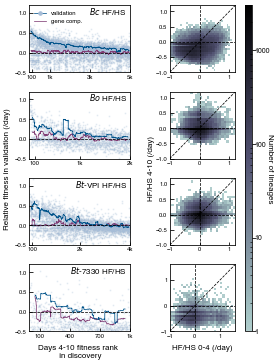

In [64]:
RANK_ORDER_FORMATS = {'BWH2': (20000, [1000, 5000, 10000, 15000, 19000], ['1000', '5000', '10000', '15000', '19000']),
                      'Bovatus': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'BtVPI': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'Bt7330': (5000, [500, 1500, 2500, 3500, 4500], ['500', '1500', '2500', '3500', '4500'])}

fig = plt.figure(figsize=(4,6))
outer = mpl.gridspec.GridSpec(nrows=7, ncols=4,
                              height_ratios=[1, 0.05, 1, 0.05, 1, 0.05, 1], width_ratios=[1, 0.2, 0.65,0.07], figure=fig)
diet_names = {'HF':'HF/HS', 'LF':'LF/HPP'}
if 'plot rank order curves, etc':
    min_reads = 5
    gene_nn = False
    cutoff = 10**-6.5
    cg = 100 #coarse_grain

    discovery_mice = [6, 7]
    validation_mice = [8, 9, 10]


    # discovery_mice = [6, 7, 8]
    # validation_mice = [9, 10]


    discovery_d0, discovery_d1 = 4, 10
    discovery_dt = discovery_d1 - discovery_d0
    validation_d0, validation_d1 = 4, 10
    validation_dt = validation_d1 - validation_d0

norm=mpl.colors.LogNorm(0.1, 3e3)

all_ax_rank = fig.add_subplot(outer[:, 0])
all_ax_rank.set_ylabel('Relative fitness in validation (/day)', fontsize=8, labelpad=8)
all_ax_rank.set_xlabel('Days 4-10 fitness rank \n in discovery', fontsize=8, labelpad=6)
ax_methods.turn_off_ax(all_ax_rank)

diet = 'HF/HS'
all_joint_ax = fig.add_subplot(outer[:, 2])
all_joint_ax.set_ylabel(f'{diet} 4-10 (/day)', fontsize=8, labelpad=4)
all_joint_ax.set_xlabel(f'{diet} 0-4 (/day)', fontsize=8, labelpad=6)
ax_methods.turn_off_ax(all_joint_ax)

for b, (bac, n_fit) in enumerate([('BWH2', 5000), ('Bovatus', 2000), ('BtVPI', 4000), ('Bt7330', 1000)]):
    if 'generate discovery and validation frequencies':
        discovery_reads0, discovery_reads1 = np.copy(fl.get_read_arrays(bac, discovery_mice, discovery_d0, discovery_d1, split_day0=2))
        validation_reads0, validation_reads1 = np.copy(fl.get_read_arrays(bac, validation_mice, validation_d0, validation_d1, split_day0=1))
        # discovery_reads0 -= fl.bac_input_arrays[bac][6][fl.bac_nonwu_indices[bac]]

        discovery_D0, discovery_D1 = discovery_reads0.sum(), discovery_reads1.sum()
        discovery_freqs0, discovery_freqs1 = discovery_reads0 / discovery_D0, discovery_reads1 / discovery_D1

        validation_D0, validation_D1 = validation_reads0.sum(), validation_reads1.sum()
        validation_freqs0, validation_freqs1 = validation_reads0 /validation_D0, validation_reads1 /validation_D1

        d0_reads = fl.bac_read_arrays[bac][0][fl.bac_nonwu_indices[bac]]
        d0_freqs = d0_reads / d0_reads.sum()
        d1_reads = (discovery_reads1 + validation_reads1)

        max_freqs = np.max([discovery_freqs0, discovery_freqs1], axis=0)
        d_valid = fl.filter_lineages(discovery_reads0, discovery_reads1, min_reads=min_reads, threshold=max_freqs)
        v_valid = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=min_reads, threshold=max_freqs)

        filtered_bool =  (d0_freqs > cutoff) * v_valid * d_valid
        lineage_indices = rnd.permutation( np.arange(d0_freqs.shape[-1])[filtered_bool] )

        d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_D0, discovery_freqs1, discovery_D1)
        v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_D0, validation_freqs1, validation_D1)

    if 'generate sorted fitnesses':
        # n_fit = len(lineage_indices)
        fit_indices, sorted_fitnesses = fl.rank_barcodes(d_f0[lineage_indices], d_f1[lineage_indices], discovery_dt)
        fit_indices = lineage_indices[fit_indices]

        # n_fit = filtered_bool.sum()
        v_f0_fit, v_f1_fit = v_f0[fit_indices][:n_fit], v_f1[fit_indices][:n_fit]
        d_freqs0_fit, d_freqs1_fit = discovery_freqs0[fit_indices][:n_fit], discovery_freqs1[fit_indices][:n_fit]
        v_freqs0_fit, v_freqs1_fit = validation_freqs0[fit_indices][:n_fit], validation_freqs1[fit_indices][:n_fit]
        validation_lfcs = fl.calc_lfc_array(v_f0_fit, v_f1_fit, validation_dt)

        cg_validate_lfcs = calc_coarse_grained_lfc_array(v_freqs0_fit, validation_D0, v_freqs1_fit, validation_D1,
                                                         validation_dt, coarse_grain=cg)
        gene_complement_f0, gene_complement_f1 = fl.calc_gene_complement_freqs(bac, fit_indices[:n_fit], validation_freqs0, validation_freqs1, nearest_neighbors=gene_nn, cutoff=cutoff)
        cg_gene_complement_lfcs = calc_coarse_grained_lfc_array(gene_complement_f0, validation_D0, gene_complement_f1, validation_D1,
                                                                validation_dt, coarse_grain=cg)

    if 'rank order plot':
        ax_rank_order = fig.add_subplot(outer[2*b, 0])
        # ax_rank_order.plot(np.arange(n_fit), sorted_fitnesses[:n_fit], KELLY_COLORS[4], label="discovery fitness")
        ax_rank_order.scatter(np.arange(validation_lfcs.shape[-1]), validation_lfcs, s=1, color=KELLY_COLORS[3], rasterized=True, zorder=0, alpha=0.2)
        ax_rank_order.plot(np.arange(cg_validate_lfcs.shape[-1])[cg//2:-cg//2],
                            cg_validate_lfcs[cg//2:-cg//2], KELLY_COLORS[9], label="coarse-grained lineage")
        ax_rank_order.plot(np.arange(cg_gene_complement_lfcs.shape[-1])[cg//2:-cg//2],
                            cg_gene_complement_lfcs[cg//2:-cg//2], KELLY_COLORS[1], zorder=0, label="gene complement")

        # muller_lineages = []
        # for mouse in [6, 7, 8, 9, 10]:
        #     muller_lineages += muller_lineage_dict[bac][mouse]
        # repeated_lineages = []
        # for i, lineage in enumerate(muller_lineages):
        #     if lineage in muller_lineages[i+1:]:
        #         repeated_lineages.append(lineage)
        # muller_lineages = set(repeated_lineages)
        # # muller_lineages = set(muller_lineages)
        # muller_ranks = []
        # for muller_lineage in muller_lineages:
        #     try: muller_ranks.append(np.where(fit_indices[:n_fit]==muller_lineage)[0][0])
        #     except: continue
        # muller_ranks = np.array(muller_ranks)
        #
        # ax_rank_order.scatter(np.arange(validation_lfcs.shape[-1])[muller_ranks], validation_lfcs[muller_ranks], s=5, marker='*', edgecolors=DIET_COLORS['HF'], rasterized=True, zorder=10)

        if bac == 'BWH2':
            legend_markers = [ax_methods.make_marker_obj(color=KELLY_COLORS[9], marker='o', mec=KELLY_COLORS[3], mfc=KELLY_COLORS[3], markersize=3.5),
                              ax_methods.make_marker_obj(color=KELLY_COLORS[1]),
                              ax_methods.make_marker_obj(color=DIET_COLORS['HF'], linewidth=0, marker='*', mfc=DIET_COLORS['HF'], mec=DIET_COLORS['HF'], markersize=3.5)]
            ax_rank_order.legend(legend_markers, ['validation', 'gene comp.'],
                                 frameon=False, fontsize=6, loc=2)

    if 'format rank order plot':
        # _, xticks, xtick_labels = RANK_ORDER_FORMATS[bac]
        # ax_rank_order.set_xticks(xticks)
        # ax_rank_order.set_xticklabels(xtick_labels)
        ax_rank_order.set_xlim(-n_fit/100, n_fit)
        ax_rank_order.set_ylim(-0.5, 1.2)
        y_ticks = [-0.4, 0, 0.4, 0.8, 1.2]
        if bac == 'BWH2':
            x_ticks = [100, 1000, 3000, 5000]
            x_labs = ['100', '1k', '3k', '5k']
        if bac == 'Bovatus':
            x_ticks = [100, 1000, 2000]
            x_labs = ['100', '1k', '2k']
        if bac == 'BtVPI':
            x_ticks = [100, 2000, 4000]
            x_labs = ['100', '2k', '4k']
        if bac == 'Bt7330':
            x_ticks = [100, 400, 700, 1000]
            x_labs = ['100', '400', '700', '1k']
        ax_rank_order.set_xticks(x_ticks)
        ax_rank_order.set_xticklabels(x_labs)
        ax_rank_order.tick_params(axis='both', labelsize=6)

        # if bac == 'Bt7330':
            # ax_rank_order.set_ylim(-0.6, 1.8)
            # y_ticks = [-0.4, 0, 0.4, 0.8, 1.2, 1.6]
        # ax_rank_order.set_yticks(y_ticks, fontsize=40)
        ax_rank_order.axhline(0, color='black', linestyle='dashed')
        ax_rank_order.text(0.97, 0.86, f'{BAC_FORMAL_NAMES[bac]} HF/HS',
                           transform=ax_rank_order.transAxes, horizontalalignment='right')
        # ax_rank_order.text(0.03, 0.88, f'{BAC_FORMAL_NAMES[bac]} LF/HPP',
        #                    transform=ax_rank_order.transAxes, horizontalalignment='left')
        # ax_rank_order.text(-0.05, 1.05, panel_indices[bac][0], fontsize=8, transform=ax_rank_order.transAxes)

    if 'heat map':
        m1, m2 = discovery_mice, validation_mice
        m1t0, m1t1 = 0, 4
        m2t0, m2t1 = 4, 10
        diet1, diet2 = mouse2diet[m1[0]], mouse2diet[m2[0]]
        xlabel = f'{diet1}/HPP {m1t0}-{m1t1}'
        ylabel = f'{diet2}/HPP {m2t0}-{m2t1}'

        m1_tuple = (m1, m1t0, m1t1)
        m2_tuple = (m2, m2t0, m2t1)

        ax = fig.add_subplot(outer[2*b, 2])
        # if c == 1:
        #     muller=False
        # else:
        #     muller=False
        muller=False
        plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple, colorbar=False,
                                   norm=norm,cmap=mpl.cm.bone_r, plot_muller=muller)
        # ax.text(0.1, 0.9, BAC_FORMAL_NAMES[bac], transform=ax.transAxes)


        if bac == 'BWH2': min, max = -1.0, 1.2
        elif bac == 'BtVPI': min, max = -1.0, 1.2
        elif bac == 'Bovatus': min, max = -1.0, 1.2
        elif bac == 'Bt7330': min, max = -1.0, 1.6
        ax.set_xlim(min, max)
        ax.set_ylim(min, max)

        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dashed', color='black')
        ax.axvline(0, color='black', linestyle='dashed', zorder=5)
        ax.axhline(0, color='black', linestyle='dashed', zorder=5)
        ax.tick_params(axis='both', labelsize=6)

if 'colorbar':
    colorbar_ax = fig.add_subplot(outer[:, -1])
    _ = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=mpl.cm.bone_r, norm=norm)
    colorbar_ax.tick_params(axis='both', direction='out', labelsize=7, pad=-1)
    # colorbar_ax.set_title('# lineages', fontsize=8)
    # colorbar_ax.set_ylabel('# lineages', fontsize=8, labelpad=8, rotation=-90)
    colorbar_ax.set_ylim(1, 3000)
    colorbar_ax.set_yticks([1, 10, 100, 1000])
    colorbar_ax.set_yticklabels(['1', '10', '100', '1000'])
    colorbar_ax.set_ylabel('Number of lineages', fontsize=8, labelpad=3, rotation=-90)
    # colorbar_ax.text(0.35, 2, '# lineages', transform=colorbar_ax.transAxes, fontsize=12)


fig.savefig(f'{biorxiv}/SI_day410_HF_rank_order.pdf')


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.l

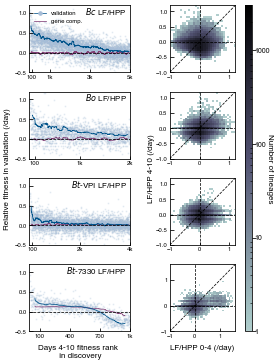

In [63]:
RANK_ORDER_FORMATS = {'BWH2': (20000, [1000, 5000, 10000, 15000, 19000], ['1000', '5000', '10000', '15000', '19000']),
                      'Bovatus': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'BtVPI': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'Bt7330': (5000, [500, 1500, 2500, 3500, 4500], ['500', '1500', '2500', '3500', '4500'])}

fig = plt.figure(figsize=(4,6))
outer = mpl.gridspec.GridSpec(nrows=7, ncols=4,
                              height_ratios=[1, 0.05, 1, 0.05, 1, 0.05, 1], width_ratios=[1, 0.2, 0.65,0.07], figure=fig)
diet_names = {'HF':'HF/HS', 'LF':'LF/HPP'}
if 'plot rank order curves, etc':
    min_reads = 5
    gene_nn = False
    cutoff = 10**-6.5
    cg = 100 #coarse_grain


    discovery_mice = [16, 18]
    validation_mice = [19]

    discovery_d0, discovery_d1 = 4, 10
    discovery_dt = discovery_d1 - discovery_d0
    validation_d0, validation_d1 = 4, 10
    validation_dt = validation_d1 - validation_d0

norm=mpl.colors.LogNorm(0.1, 3e3)

all_ax_rank = fig.add_subplot(outer[:, 0])
all_ax_rank.set_ylabel('Relative fitness in validation (/day)', fontsize=8, labelpad=8)
all_ax_rank.set_xlabel('Days 4-10 fitness rank \n in discovery', fontsize=8, labelpad=6)
ax_methods.turn_off_ax(all_ax_rank)

diet = 'LF/HPP'
all_joint_ax = fig.add_subplot(outer[:, 2])
all_joint_ax.set_ylabel(f'{diet} 4-10 (/day)', fontsize=8, labelpad=4)
all_joint_ax.set_xlabel(f'{diet} 0-4 (/day)', fontsize=8, labelpad=6)
ax_methods.turn_off_ax(all_joint_ax)

for b, (bac, n_fit) in enumerate([('BWH2', 5000), ('Bovatus', 2000), ('BtVPI', 4000), ('Bt7330', 1000)]):
    if 'generate discovery and validation frequencies':
        discovery_reads0, discovery_reads1 = np.copy(fl.get_read_arrays(bac, discovery_mice, discovery_d0, discovery_d1, split_day0=2))
        validation_reads0, validation_reads1 = np.copy(fl.get_read_arrays(bac, validation_mice, validation_d0, validation_d1, split_day0=1))
        # discovery_reads0 -= fl.bac_input_arrays[bac][6][fl.bac_nonwu_indices[bac]]

        discovery_D0, discovery_D1 = discovery_reads0.sum(), discovery_reads1.sum()
        discovery_freqs0, discovery_freqs1 = discovery_reads0 / discovery_D0, discovery_reads1 / discovery_D1

        validation_D0, validation_D1 = validation_reads0.sum(), validation_reads1.sum()
        validation_freqs0, validation_freqs1 = validation_reads0 /validation_D0, validation_reads1 /validation_D1

        d0_reads = fl.bac_read_arrays[bac][0][fl.bac_nonwu_indices[bac]]
        d0_freqs = d0_reads / d0_reads.sum()
        d1_reads = (discovery_reads1 + validation_reads1)

        max_freqs = np.max([discovery_freqs0, discovery_freqs1], axis=0)
        d_valid = fl.filter_lineages(discovery_reads0, discovery_reads1, min_reads=min_reads, threshold=max_freqs)
        v_valid = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=min_reads, threshold=max_freqs)

        filtered_bool =  (d0_freqs > cutoff) * v_valid * d_valid
        lineage_indices = rnd.permutation( np.arange(d0_freqs.shape[-1])[filtered_bool] )

        d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_D0, discovery_freqs1, discovery_D1)
        v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_D0, validation_freqs1, validation_D1)

    if 'generate sorted fitnesses':
        # n_fit = len(lineage_indices)
        fit_indices, sorted_fitnesses = fl.rank_barcodes(d_f0[lineage_indices], d_f1[lineage_indices], discovery_dt)
        fit_indices = lineage_indices[fit_indices]

        # n_fit = filtered_bool.sum()
        v_f0_fit, v_f1_fit = v_f0[fit_indices][:n_fit], v_f1[fit_indices][:n_fit]
        d_freqs0_fit, d_freqs1_fit = discovery_freqs0[fit_indices][:n_fit], discovery_freqs1[fit_indices][:n_fit]
        v_freqs0_fit, v_freqs1_fit = validation_freqs0[fit_indices][:n_fit], validation_freqs1[fit_indices][:n_fit]
        validation_lfcs = fl.calc_lfc_array(v_f0_fit, v_f1_fit, validation_dt)

        cg_validate_lfcs = calc_coarse_grained_lfc_array(v_freqs0_fit, validation_D0, v_freqs1_fit, validation_D1,
                                                         validation_dt, coarse_grain=cg)
        gene_complement_f0, gene_complement_f1 = fl.calc_gene_complement_freqs(bac, fit_indices[:n_fit], validation_freqs0, validation_freqs1, nearest_neighbors=gene_nn, cutoff=cutoff)
        cg_gene_complement_lfcs = calc_coarse_grained_lfc_array(gene_complement_f0, validation_D0, gene_complement_f1, validation_D1,
                                                                validation_dt, coarse_grain=cg)

    if 'rank order plot':
        ax_rank_order = fig.add_subplot(outer[2*b, 0])
        # ax_rank_order.plot(np.arange(n_fit), sorted_fitnesses[:n_fit], KELLY_COLORS[4], label="discovery fitness")
        ax_rank_order.scatter(np.arange(validation_lfcs.shape[-1]), validation_lfcs, s=1, color=KELLY_COLORS[3], rasterized=True, zorder=0, alpha=0.2)
        ax_rank_order.plot(np.arange(cg_validate_lfcs.shape[-1])[cg//2:-cg//2],
                            cg_validate_lfcs[cg//2:-cg//2], KELLY_COLORS[9], label="coarse-grained lineage")
        ax_rank_order.plot(np.arange(cg_gene_complement_lfcs.shape[-1])[cg//2:-cg//2],
                            cg_gene_complement_lfcs[cg//2:-cg//2], KELLY_COLORS[1], zorder=0, label="gene complement")

        # muller_lineages = []
        # for mouse in [6, 7, 8, 9, 10]:
        #     muller_lineages += muller_lineage_dict[bac][mouse]
        # repeated_lineages = []
        # for i, lineage in enumerate(muller_lineages):
        #     if lineage in muller_lineages[i+1:]:
        #         repeated_lineages.append(lineage)
        # muller_lineages = set(repeated_lineages)
        # # muller_lineages = set(muller_lineages)
        # muller_ranks = []
        # for muller_lineage in muller_lineages:
        #     try: muller_ranks.append(np.where(fit_indices[:n_fit]==muller_lineage)[0][0])
        #     except: continue
        # muller_ranks = np.array(muller_ranks)
        #
        # ax_rank_order.scatter(np.arange(validation_lfcs.shape[-1])[muller_ranks], validation_lfcs[muller_ranks], s=5, marker='*', edgecolors=DIET_COLORS['HF'], rasterized=True, zorder=10)

        if bac == 'BWH2':
            legend_markers = [ax_methods.make_marker_obj(color=KELLY_COLORS[9], marker='o', mec=KELLY_COLORS[3], mfc=KELLY_COLORS[3], markersize=3.5),
                              ax_methods.make_marker_obj(color=KELLY_COLORS[1]),
                              ax_methods.make_marker_obj(color=DIET_COLORS['HF'], linewidth=0, marker='*', mfc=DIET_COLORS['HF'], mec=DIET_COLORS['HF'], markersize=3.5)]
            ax_rank_order.legend(legend_markers, ['validation', 'gene comp.'],
                                 frameon=False, fontsize=6, loc=2)

    if 'format rank order plot':
        # _, xticks, xtick_labels = RANK_ORDER_FORMATS[bac]
        # ax_rank_order.set_xticks(xticks)
        # ax_rank_order.set_xticklabels(xtick_labels)
        ax_rank_order.set_xlim(-n_fit/100, n_fit)
        ax_rank_order.set_ylim(-0.5, 1.2)
        y_ticks = [-0.4, 0, 0.4, 0.8, 1.2]
        if bac == 'BWH2':
            x_ticks = [100, 1000, 3000, 5000]
            x_labs = ['100', '1k', '3k', '5k']
        if bac == 'Bovatus':
            x_ticks = [100, 1000, 2000]
            x_labs = ['100', '1k', '2k']
        if bac == 'BtVPI':
            x_ticks = [100, 2000, 4000]
            x_labs = ['100', '2k', '4k']
        if bac == 'Bt7330':
            x_ticks = [100, 400, 700, 1000]
            x_labs = ['100', '400', '700', '1k']
        ax_rank_order.set_xticks(x_ticks)
        ax_rank_order.set_xticklabels(x_labs)
        ax_rank_order.tick_params(axis='both', labelsize=6)

        # if bac == 'Bt7330':
            # ax_rank_order.set_ylim(-0.6, 1.8)
            # y_ticks = [-0.4, 0, 0.4, 0.8, 1.2, 1.6]
        # ax_rank_order.set_yticks(y_ticks, fontsize=40)
        ax_rank_order.axhline(0, color='black', linestyle='dashed')
        ax_rank_order.text(0.97, 0.86, f'{BAC_FORMAL_NAMES[bac]} LF/HPP',
                           transform=ax_rank_order.transAxes, horizontalalignment='right')
        # ax_rank_order.text(0.03, 0.88, f'{BAC_FORMAL_NAMES[bac]} LF/HPP',
        #                    transform=ax_rank_order.transAxes, horizontalalignment='left')
        # ax_rank_order.text(-0.05, 1.05, panel_indices[bac][0], fontsize=8, transform=ax_rank_order.transAxes)

    if 'heat map':
        m1, m2 = discovery_mice, validation_mice
        m1t0, m1t1 = 0, 4
        m2t0, m2t1 = 4, 10
        diet1, diet2 = mouse2diet[m1[0]], mouse2diet[m2[0]]
        xlabel = f'{diet1}/HPP {m1t0}-{m1t1}'
        ylabel = f'{diet2}/HPP {m2t0}-{m2t1}'

        m1_tuple = (m1, m1t0, m1t1)
        m2_tuple = (m2, m2t0, m2t1)

        ax = fig.add_subplot(outer[2*b, 2])
        # if c == 1:
        #     muller=False
        # else:
        #     muller=False
        muller=False
        plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple, colorbar=False,
                                   norm=norm,cmap=mpl.cm.bone_r, plot_muller=muller)
        # ax.text(0.1, 0.9, BAC_FORMAL_NAMES[bac], transform=ax.transAxes)


        if bac == 'BWH2': min, max = -1.0, 1.2
        elif bac == 'BtVPI': min, max = -1.0, 1.2
        elif bac == 'Bovatus': min, max = -1.0, 1.2
        elif bac == 'Bt7330': min, max = -1.0, 1.6
        ax.set_xlim(min, max)
        ax.set_ylim(min, max)

        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dashed', color='black')
        ax.axvline(0, color='black', linestyle='dashed', zorder=5)
        ax.axhline(0, color='black', linestyle='dashed', zorder=5)
        ax.tick_params(axis='both', labelsize=6)
if 'colorbar':
    colorbar_ax = fig.add_subplot(outer[:, -1])
    _ = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=mpl.cm.bone_r, norm=norm)
    colorbar_ax.tick_params(axis='both', direction='out', labelsize=7, pad=-1)
    # colorbar_ax.set_title('# lineages', fontsize=8)
    # colorbar_ax.set_ylabel('# lineages', fontsize=8, labelpad=8, rotation=-90)
    colorbar_ax.set_ylim(1, 3000)
    colorbar_ax.set_yticks([1, 10, 100, 1000])
    colorbar_ax.set_yticklabels(['1', '10', '100', '1000'])
    colorbar_ax.set_ylabel('Number of lineages', fontsize=8, labelpad=3, rotation=-90)
    # colorbar_ax.text(0.35, 2, '# lineages', transform=colorbar_ax.transAxes, fontsize=12)


fig.savefig(f'{biorxiv}/SI_day410_LF_rank_order.pdf')


In [24]:
# bac = 'Bt7330'
# for i in range(1, 23):
#     Ri = bac_input_arrays[bac][i]
#     for j in range(i+1, 24):
#         Rj = bac_input_arrays[bac][j]
#         fig, ax = plt.subplots()
#         ax.scatter(Ri, Rj, rasterized=True)
#         ax.set_xscale('log')
#         ax.set_yscale('log')
#         ax.set_title(f'{i}, {j}')